> # __CF-OPT__ | Counterfactual Explanations for Data-Driven Optimization Pipelines
> ## Shortest paths on a grid : __Workflow__

We use the framework provided by __Bo Tang__, __Elias B.__ and __Khalil__ _via_ their [PyEPO: A PyTorch-based End-to-End Predict-then-Optimize Tool](https://github.com/khalil-research/PyEPO) GitHub repository.

## __Setting up__ the Pipeline

A few preliminary steps are necessary to set up the pipeline to explain :

* Loading the __data__,

* Setting up the __optimization solver__,

* Setting up the __Linear Regression__ model ( you can train it from scratch or simply load the weights if a model save of the same architecture is available ).

#### Imports

In [5]:
import torch
import numpy as np

#### Device

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Datasets and DataLoaders

In [ ]:
# Imports
from src.dataloading.dataloader import get_grid_dataloaders_and_dataset

In [ ]:
num_feat = 5
n = 1000
grid = (5,5)
deg = 4
e = 0.5
dataset_train, dataset_test, loader_train, loader_test = get_grid_dataloaders_and_dataset(grid, n, num_feat, deg, e)

#### Shortest Path Optimization Model

In [10]:
# Imports
from src.optimization.ShortestPathModel import ShortestPathModel

In [11]:
# Optimization model
optmodel = ShortestPathModel(grid, task="grid")

#### Prediction model: Linear regression

##### Initializing the model

In [12]:
# Imports
from src.prediction.prediction_models import LinearRegression
from src.prediction.train_prediction_model import train_prediction_model

In [8]:
# Initialize linear regression
reg = LinearRegression(num_feat, grid)

##### Training the linear regression from scratch <span style="color:red">( You can also skip and directly load a trained model )</span>

In [9]:
%load_ext tensorboard

In [10]:
train_prediction_model(reg, optmodel, loader_train, loader_test, 0, 100, 3e-4, device, write_tb=True, use_spo_loss=True, save_path="./models/lin_reg_model_saves/", save_frequency=1)
reg.eval()

##### Else: Loading the Linear regression model

In [ ]:
reg.load_state_dict(torch.load("models/lin_reg_model_saves/LinReg_SPO_epoch_70.pth", map_location=device))
reg.eval()

##### Freezing the weights of the Linear Regression model

In [12]:
for param in reg.parameters():
    param.requires_grad = False

## __Explaining__ the Pipeline with __CF-OPT__

### Running  __CF-OPT__

To run __CF-OPT__, we use the following function:
* `get_counterfactual` : Uses a modified version of the [_MDMM_](https://proceedings.neurips.cc/paper_files/paper/1987/file/a87ff679a2f3e71d9181a67b7542122c-Paper.pdf) optimization method ( performs gradient descent on the input and gradient ascent on the Lagrange multiplier at each step ) from Platt and Barr in order to obtain the counterfactual explanation. The implementation of the MDMM used comes from [this](https://github.com/crowsonkb/mdmm/tree/master) GitHub repository. This method needs the user to set only very few hyperparameters.

An `initial_index` and an `alternative_index` are required to run the function. 

The `initial_index` represents the index ( in the test dataset ) of the initial context, and consequently of its associated predicted costs and predicted optimal s olution. 

The `alternative_index` represents the index of another context in the test dataset, but is only used to query its associated true optimal solution : it will be the __alternative decision__ in the counterfactual explanation process. 

Thus, the `alternative_index` is not used if the `explanation_type` is set to `epsilon` ( as $\varepsilon$-explanations do not require an alternative decision ).

In [18]:
# Imports
from src.counterfactual.cf_opt import get_counterfactual

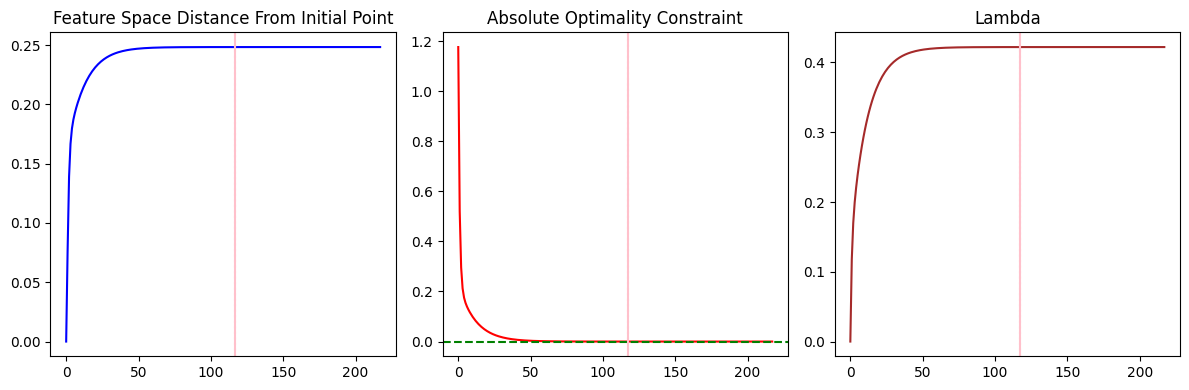

(0.24830807745456696, 218, -1.1920928955078125e-07)

In [190]:
get_counterfactual(pred_model=reg,
                   dataset=dataset_test, 
                   initial_index=15, 
                   alternative_index=44,
                   grid=grid, 
                   explanation_type="absolute",
                   epsilon=1,
                   step_size=0.1,
                   plot_result=1)

## Numerical __Experiments__

In [13]:
import matplotlib.pyplot as plt
import random as rd
import time
from tqdm import tqdm

#### Varying __contextual dimension__

In [192]:
n = 1000
grid = (5,5)
deg = 4
e = 0.5

rel_exp_context = [[None] * 100 for _ in range(11)]
abs_exp_context = [[None] * 100 for _ in range(11)]
eps_exp_context = [[None] * 100 for _ in range(11)]

In [ ]:
for i, num_feat in enumerate(tqdm([5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100])):
    dataset_train, dataset_test, loader_train, loader_test = get_grid_dataloaders_and_dataset(grid, n, num_feat, deg, e)
    optmodel = ShortestPathModel(grid, task="grid")
    reg = LinearRegression(num_feat, grid)
    train_prediction_model(reg, optmodel, loader_train, loader_test, 0, 70, 3e-4, device, write_tb=True, use_spo_loss=False, save_frequency=0)
    reg.eval()
    for param in reg.parameters():
        param.requires_grad = False

    for k in range(100):
        init_index = rd.randint(0 ,len(dataset_test)-1)
        alter_index = rd.randint(0 ,len(dataset_test)-1)
        while torch.equal(dataset_test[alter_index][2],dataset_test[init_index][2]):
            alter_index = rd.randint(0 ,len(dataset_test)-1)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual(pred_model=reg,
                                                                  dataset=dataset_test, 
                                                                  initial_index=init_index, 
                                                                  alternative_index=alter_index,
                                                                  grid=grid, 
                                                                  explanation_type="relative",
                                                                  epsilon=1,
                                                                  step_size=0.1,
                                                                  plot_result=0,
                                                                  max_countdown=10)
        b = time.time()
        comptime = b-a
        rel_exp_context[i][k] = (distance, n_iterations, constraint, comptime)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual(pred_model=reg,
                                                                  dataset=dataset_test, 
                                                                  initial_index=init_index, 
                                                                  alternative_index=alter_index,
                                                                  grid=grid, 
                                                                  explanation_type="absolute",
                                                                  epsilon=1,
                                                                  step_size=0.1,
                                                                  plot_result=0,
                                                                  max_countdown=10)
        b = time.time()
        comptime = b-a
        abs_exp_context[i][k] = (distance, n_iterations, constraint, comptime)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual(pred_model=reg,
                                                                  dataset=dataset_test, 
                                                                  initial_index=init_index, 
                                                                  alternative_index=alter_index,
                                                                  grid=grid, 
                                                                  explanation_type="epsilon",
                                                                  epsilon=1,
                                                                  step_size=0.1,
                                                                  plot_result=0,
                                                                  max_countdown=10)
        b = time.time()
        comptime = b-a
        eps_exp_context[i][k] = (distance, n_iterations, constraint, comptime)

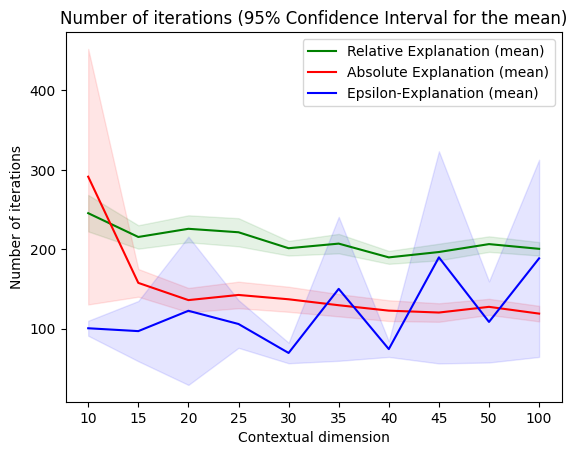

In [226]:
rel_comp_context = [[rel_exp_context[i][k][1] for k in range(100)] for i in range(1,11)]
abs_comp_context = [[abs_exp_context[i][k][1] for k in range(100)] for i in range(1,11)]
eps_comp_context = [[eps_exp_context[i][k][1] for k in range(100)] for i in range(1,11)]

rel_std_context = np.std(rel_comp_context, axis=1)
rel_mean_context = np.mean(rel_comp_context, axis=1)
abs_std_context = np.std(abs_comp_context, axis=1)
abs_mean_context = np.mean(abs_comp_context, axis=1)
eps_std_context = np.std(eps_comp_context, axis=1)
eps_mean_context = np.mean(eps_comp_context, axis=1)

plt.plot(rel_mean_context, label='Relative Explanation (mean)', color='green')
plt.fill_between(range(len(rel_mean_context)), rel_mean_context - 1.96 * rel_std_context/10, rel_mean_context + 1.96 * rel_std_context/10, color='green', alpha=0.1)

plt.plot(abs_mean_context, label='Absolute Explanation (mean)', color='red')
plt.fill_between(range(len(abs_mean_context)), abs_mean_context - 1.96 * abs_std_context/10, abs_mean_context + 1.96 * abs_std_context/10, color='red', alpha=0.1)

plt.plot(eps_mean_context, label='Epsilon-Explanation (mean)', color='blue')
plt.fill_between(range(len(eps_mean_context)), eps_mean_context - 1.96 * eps_std_context/10, eps_mean_context + 1.96 * eps_std_context/10, color='blue', alpha=0.1)

# Customize the plot as needed
plt.xticks(range(10), [10, 15, 20, 25, 30, 35, 40, 45, 50, 100])
plt.xlabel('Contextual dimension')
plt.ylabel('Number of iterations')
plt.title('Number of iterations (95% Confidence Interval for the mean)')
plt.legend()

# Show the plot
plt.show()

#### Varying __grid size__

In [212]:
num_feat = 10
n = 1000
deg = 4
e = 0.5

rel_exp_grid = [[None] * 100 for _ in range(6)]
abs_exp_grid = [[None] * 100 for _ in range(6)]
eps_exp_grid = [[None] * 100 for _ in range(6)]

In [ ]:
for i, grid in enumerate(tqdm([(2,2), (3,3), (4,4), (5,5), (7,7), (10,10)])):
    dataset_train, dataset_test, loader_train, loader_test = get_grid_dataloaders_and_dataset(grid, n, num_feat, deg, e)
    optmodel = ShortestPathModel(grid, task="grid")
    reg = LinearRegression(num_feat, grid)
    train_prediction_model(reg, optmodel, loader_train, loader_test, 0, 70, 3e-4, device, write_tb=True, use_spo_loss=True, save_frequency=0)
    reg.eval()
    for param in reg.parameters():
        param.requires_grad = False

    for k in range(100):
        init_index = rd.randint(0 ,len(dataset_test)-1)
        alter_index = rd.randint(0 ,len(dataset_test)-1)
        while torch.equal(dataset_test[alter_index][2],dataset_test[init_index][2]):
            alter_index = rd.randint(0 ,len(dataset_test)-1)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual(pred_model=reg,
                                                                  dataset=dataset_test, 
                                                                  initial_index=init_index, 
                                                                  alternative_index=alter_index,
                                                                  grid=grid, 
                                                                  explanation_type="relative",
                                                                  epsilon=1,
                                                                  step_size=0.1,
                                                                  plot_result=0,
                                                                  max_countdown=10)
        b = time.time()
        comptime = b-a
        rel_exp_grid[i][k] = (distance, n_iterations, constraint, comptime)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual(pred_model=reg,
                                                                  dataset=dataset_test, 
                                                                  initial_index=init_index, 
                                                                  alternative_index=alter_index,
                                                                  grid=grid, 
                                                                  explanation_type="absolute",
                                                                  epsilon=1,
                                                                  step_size=0.1,
                                                                  plot_result=0,
                                                                  max_countdown=10)
        b = time.time()
        comptime = b-a
        abs_exp_grid[i][k] = (distance, n_iterations, constraint, comptime)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual(pred_model=reg,
                                                                  dataset=dataset_test, 
                                                                  initial_index=init_index, 
                                                                  alternative_index=alter_index,
                                                                  grid=grid, 
                                                                  explanation_type="epsilon",
                                                                  epsilon=1,
                                                                  step_size=0.1,
                                                                  plot_result=0,
                                                                  max_countdown=10)
        b = time.time()
        comptime = b-a
        eps_exp_grid[i][k] = (distance, n_iterations, constraint, comptime)

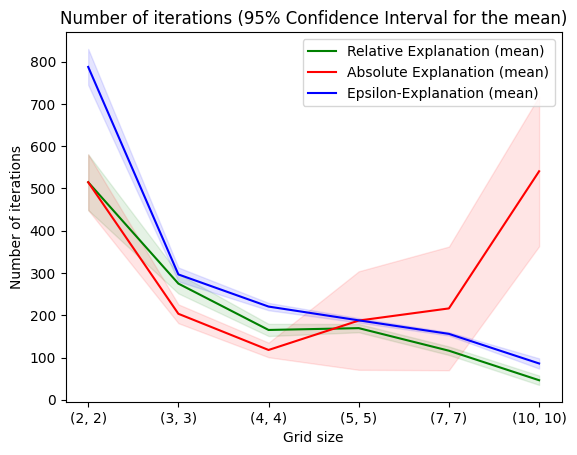

In [228]:
rel_comp_grid = [[rel_exp_grid[i][k][1] for k in range(100)] for i in range(6)]
abs_comp_grid = [[abs_exp_grid[i][k][1] for k in range(100)] for i in range(6)]
eps_comp_grid = [[eps_exp_grid[i][k][1] for k in range(100)] for i in range(6)]

rel_std_grid = np.std(rel_comp_grid, axis=1)
rel_mean_grid = np.mean(rel_comp_grid, axis=1)
abs_std_grid = np.std(abs_comp_grid, axis=1)
abs_mean_grid = np.mean(abs_comp_grid, axis=1)
eps_std_grid = np.std(eps_comp_grid, axis=1)
eps_mean_grid = np.mean(eps_comp_grid, axis=1)

plt.plot(rel_mean_grid, label='Relative Explanation (mean)', color='green')
plt.fill_between(range(len(rel_mean_grid)), rel_mean_grid - 1.96 * rel_std_grid/10, rel_mean_grid + 1.96 * rel_std_grid/10, color='green', alpha=0.1)

plt.plot(abs_mean_grid, label='Absolute Explanation (mean)', color='red')
plt.fill_between(range(len(abs_mean_grid)), abs_mean_grid - 1.96 * abs_std_grid/10, abs_mean_grid + 1.96 * abs_std_grid/10, color='red', alpha=0.1)

plt.plot(eps_mean_grid, label='Epsilon-Explanation (mean)', color='blue')
plt.fill_between(range(len(eps_mean_grid)), eps_mean_grid - 1.96 * eps_std_grid/10, eps_mean_grid + 1.96 * eps_std_grid/10, color='blue', alpha=0.1)

# Customize the plot as needed
plt.xticks(range(6), [(2,2), (3,3), (4,4), (5,5), (7,7), (10,10)])
plt.xlabel('Grid size')
plt.ylabel('Number of iterations')
plt.title('Number of iterations (95% Confidence Interval for the mean)')
plt.legend()

#### Distance from initial context for varying __epsilon__

In [ ]:
num_feat = 10
n = 1000
grid = (5,5)
deg = 4
e = 0.5

eps_exp_eps = [[None] * 100 for _ in range(8)]

dataset_train, dataset_test, loader_train, loader_test = get_grid_dataloaders_and_dataset(grid, n, num_feat, deg, e)
optmodel = ShortestPathModel(grid, task="grid")
reg = LinearRegression(num_feat, grid)

train_prediction_model(reg, optmodel, loader_train, loader_test, 0, 70, 3e-4, device, write_tb=False, use_spo_loss=True, save_frequency=0)
reg.eval()
for param in reg.parameters():
    param.requires_grad = False

epsilons = [0.1, 0.2, 0.5, 0.7, 1, 1.5, 2, 3]

In [ ]:
for i, eps in enumerate(tqdm(epsilons)):

    for k in range(100):
        init_index = rd.randint(0 ,len(dataset_test)-1)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual(pred_model=reg,
                                                                  dataset=dataset_test, 
                                                                  initial_index=init_index, 
                                                                  alternative_index=0,
                                                                  grid=grid, 
                                                                  explanation_type="epsilon",
                                                                  epsilon=eps,
                                                                  step_size=0.1,
                                                                  plot_result=0,
                                                                  max_countdown=10)
        b = time.time()
        comptime = b-a
        eps_exp_eps[i][k] = (distance, n_iterations, constraint, comptime)

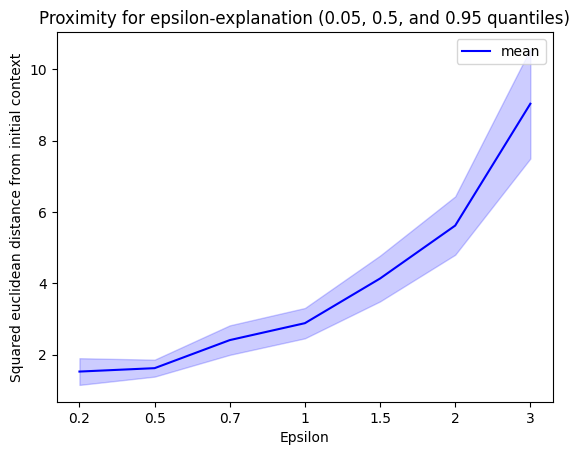

In [230]:
eps_comp_eps = [[eps_exp_eps[i][k][0] for k in range(100)] for i in range(1,8)]

eps_mean_eps = np.mean(eps_comp_eps, axis=1)
eps_std_eps = np.std(eps_comp_eps, axis=1)

plt.plot(eps_mean_eps, label='mean', color='blue')
plt.fill_between(range(len(eps_mean_eps)), eps_mean_eps - 1.96 * eps_std_eps / 10, eps_mean_eps + 1.96 * eps_std_eps / 10, color='blue', alpha=0.2)

# Customize the plot as needed
plt.xticks(range(7), [0.2, 0.5, 0.7, 1, 1.5, 2, 3])
plt.xlabel('Epsilon')
plt.ylabel('Squared euclidean distance from initial context')
plt.title('Proximity for epsilon-explanation (0.05, 0.5, and 0.95 quantiles)')
plt.legend()

#### Varying __depth__ of Feed-Forward Neural Network

In [14]:
from src.prediction.prediction_models import FeedForwardNN

In [ ]:
num_feat = 10
n = 10000
grid = (5,5)
deg = 4
e = 0.5

rel_exp_depth = [[None] * 100 for _ in range(5)]
abs_exp_depth = [[None] * 100 for _ in range(5)]
eps_exp_depth = [[None] * 100 for _ in range(5)]

dataset_train, dataset_test, loader_train, loader_test = get_grid_dataloaders_and_dataset(grid, n, num_feat, deg, e)
optmodel = ShortestPathModel(grid, task="grid")

In [ ]:
out_dim = (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0]
for i, n_layers in enumerate(tqdm([1, 2, 3, 4, 5])):
    ffnn = FeedForwardNN(num_feat, out_dim, n_layers)
    train_prediction_model(ffnn, optmodel, loader_train, loader_test, 0, 70, 3e-4, device, write_tb=True, use_spo_loss=False, save_frequency=0)
    ffnn.eval()
    for param in ffnn.parameters():
        param.requires_grad = False

    for k in range(100):
        init_index = rd.randint(0 ,len(dataset_test)-1)
        alter_index = rd.randint(0 ,len(dataset_test)-1)
        while torch.equal(dataset_test[alter_index][2],dataset_test[init_index][2]):
            alter_index = rd.randint(0 ,len(dataset_test)-1)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual(pred_model=ffnn,
                                                                  dataset=dataset_test, 
                                                                  initial_index=init_index, 
                                                                  alternative_index=alter_index,
                                                                  grid=grid, 
                                                                  explanation_type="relative",
                                                                  epsilon=1,
                                                                  step_size=0.1,
                                                                  plot_result=0,
                                                                  max_countdown=10)
        b = time.time()
        comptime = b-a
        rel_exp_depth[i][k] = (distance, n_iterations, constraint, comptime)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual(pred_model=ffnn,
                                                                  dataset=dataset_test, 
                                                                  initial_index=init_index, 
                                                                  alternative_index=alter_index,
                                                                  grid=grid, 
                                                                  explanation_type="absolute",
                                                                  epsilon=1,
                                                                  step_size=0.1,
                                                                  plot_result=0,
                                                                  max_countdown=10)
        b = time.time()
        comptime = b-a
        abs_exp_depth[i][k] = (distance, n_iterations, constraint, comptime)

        a = time.time()
        (distance, n_iterations, constraint) = get_counterfactual(pred_model=ffnn,
                                                                  dataset=dataset_test, 
                                                                  initial_index=init_index, 
                                                                  alternative_index=alter_index,
                                                                  grid=grid, 
                                                                  explanation_type="epsilon",
                                                                  epsilon=1,
                                                                  step_size=0.1,
                                                                  plot_result=0,
                                                                  max_countdown=10)
        b = time.time()
        comptime = b-a
        eps_exp_depth[i][k] = (distance, n_iterations, constraint, comptime)

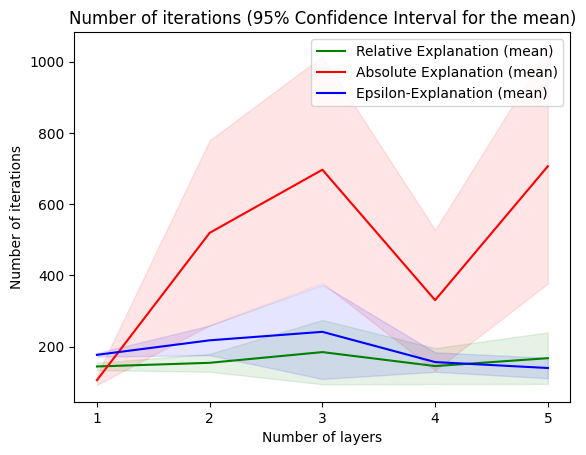

In [33]:
rel_comp_depth = [[rel_exp_depth[i][k][1] for k in range(100)] for i in range(5)]
abs_comp_depth = [[abs_exp_depth[i][k][1] for k in range(100)] for i in range(5)]
eps_comp_depth = [[eps_exp_depth[i][k][1] for k in range(100)] for i in range(5)]

rel_std_depth = np.std(rel_comp_depth, axis=1)
rel_mean_depth = np.mean(rel_comp_depth, axis=1)
abs_std_depth = np.std(abs_comp_depth, axis=1)
abs_mean_depth = np.mean(abs_comp_depth, axis=1)
eps_std_depth = np.std(eps_comp_depth, axis=1)
eps_mean_depth = np.mean(eps_comp_depth, axis=1)

plt.plot(rel_mean_depth, label='Relative Explanation (mean)', color='green')
plt.fill_between(range(len(rel_mean_depth)), rel_mean_depth - 1.96 * rel_std_depth/10, rel_mean_depth + 1.96 * rel_std_depth/10, color='green', alpha=0.1)

plt.plot(abs_mean_depth, label='Absolute Explanation (mean)', color='red')
plt.fill_between(range(len(abs_mean_depth)), abs_mean_depth - 1.96 * abs_std_depth/10, abs_mean_depth + 1.96 * abs_std_depth/10, color='red', alpha=0.1)

plt.plot(eps_mean_depth, label='Epsilon-Explanation (mean)', color='blue')
plt.fill_between(range(len(eps_mean_depth)), eps_mean_depth - 1.96 * eps_std_depth/10, eps_mean_depth + 1.96 * eps_std_depth/10, color='blue', alpha=0.1)

# Customize the plot as needed
plt.xticks(range(5), range(1, 6))
plt.xlabel('Number of layers')
plt.ylabel('Number of iterations')
plt.title('Number of iterations (95% Confidence Interval for the mean)')
plt.legend()